In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [32]:
# https://www.kaggle.com/datasets/devzohaib/dog-emotions-prediction
dogs_dir = './dogs'
data_dir = tf.keras.utils.image_dataset_from_directory(dogs_dir, labels='inferred')

Found 15921 files belonging to 4 classes.


In [3]:
len(data_dir)

498

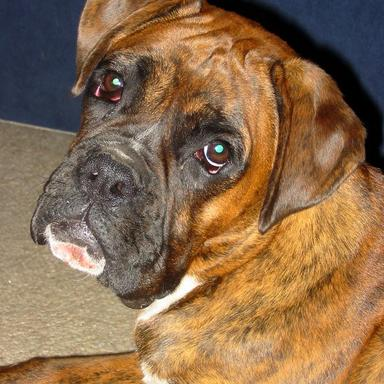

In [4]:
tf.keras.utils.load_img(
    './dogs/sad/100006702_023849cb36_b.jpg',
)

In [5]:
batch_size = 32
img_height = 384
img_width = 384

train_ds = tf.keras.utils.image_dataset_from_directory(
  dogs_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 15921 files belonging to 4 classes.
Using 12737 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dogs_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 15921 files belonging to 4 classes.
Using 3184 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['angry', 'happy', 'relaxed', 'sad']


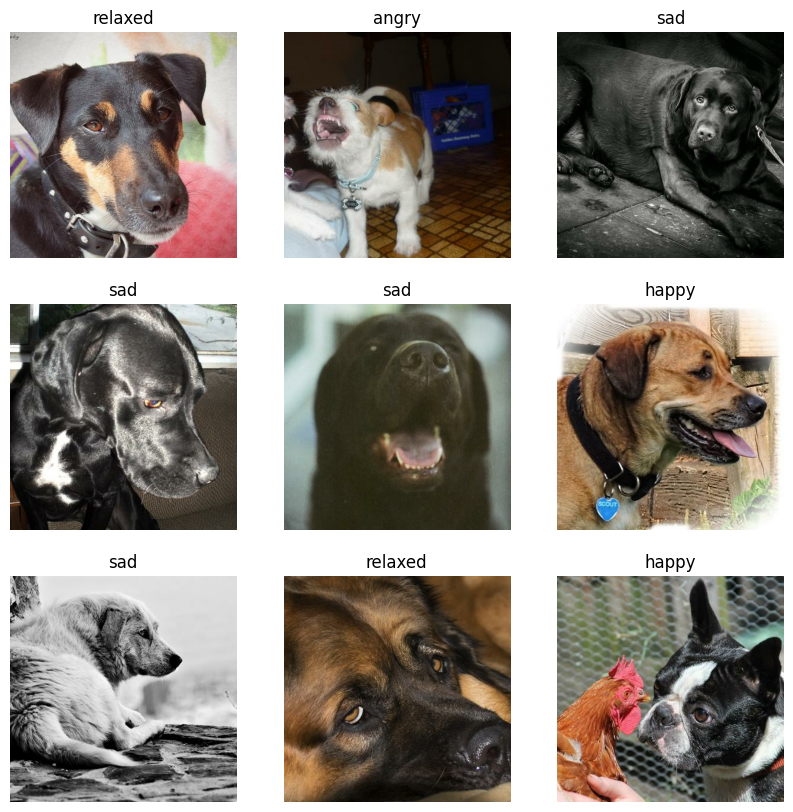

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 384, 384, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 384, 384, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 384, 384, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 192, 192, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 96, 96, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        1

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
399/399 [==============================] - 50s 107ms/step - loss: 1.4275 - accuracy: 0.3129 - val_loss: 1.3422 - val_accuracy: 0.3433
Epoch 2/10
399/399 [==============================] - 33s 83ms/step - loss: 1.3296 - accuracy: 0.3560 - val_loss: 1.3236 - val_accuracy: 0.3668
Epoch 3/10
399/399 [==============================] - 23s 57ms/step - loss: 1.2663 - accuracy: 0.4226 - val_loss: 1.3554 - val_accuracy: 0.3656
Epoch 4/10
399/399 [==============================] - 23s 57ms/step - loss: 1.0360 - accuracy: 0.5534 - val_loss: 1.5477 - val_accuracy: 0.3474
Epoch 5/10
399/399 [==============================] - 23s 57ms/step - loss: 0.6065 - accuracy: 0.7627 - val_loss: 2.3394 - val_accuracy: 0.3332
Epoch 6/10
399/399 [==============================] - 23s 57ms/step - loss: 0.2450 - accuracy: 0.9194 - val_loss: 3.4228 - val_accuracy: 0.3160
Epoch 7/10
399/399 [==============================] - 23s 59ms/step - loss: 0.1006 - accuracy: 0.9774 - val_loss: 4.1419 - val_accuracy

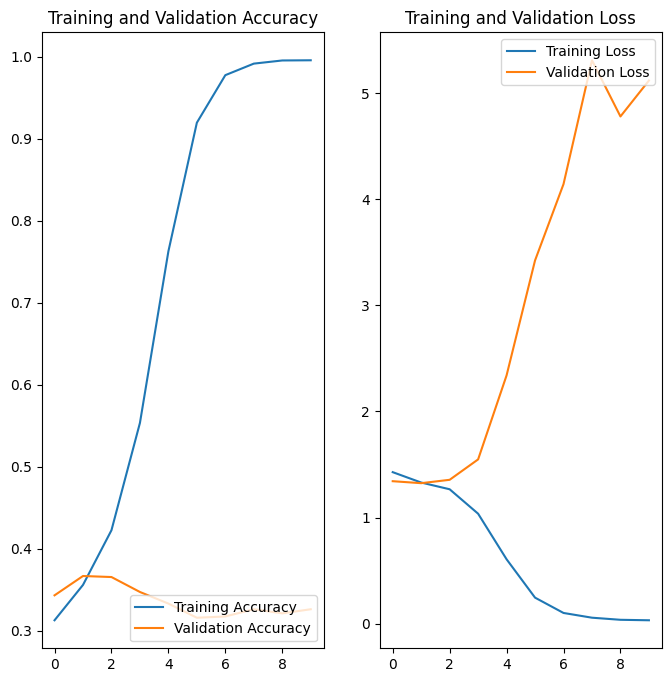

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

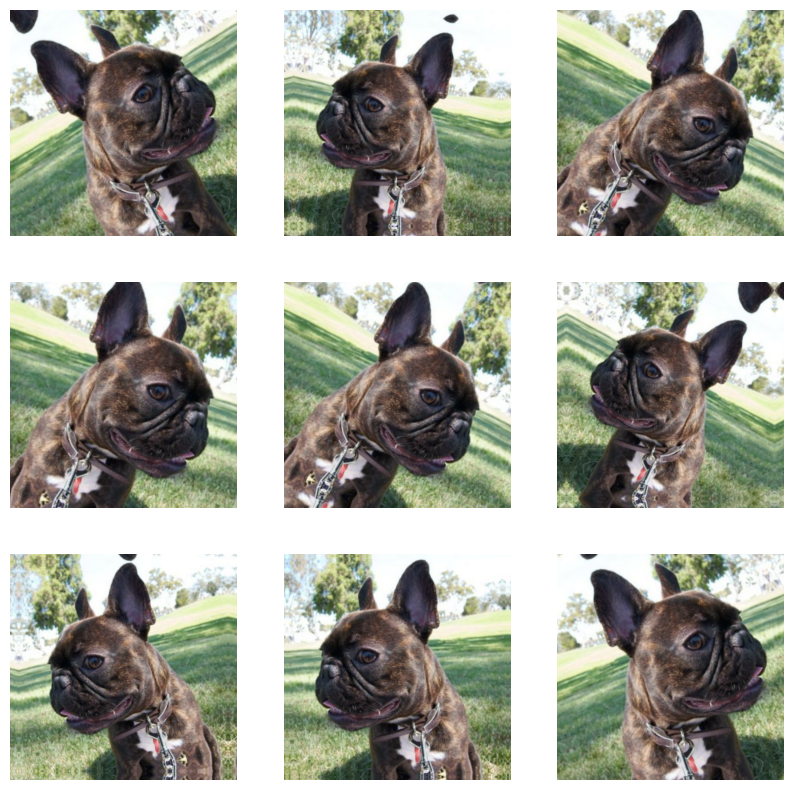

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 384, 384, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 384, 384, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 384, 384, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 192, 192, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 192, 192, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 96, 96, 32)       0         
 2D)                                                  

In [23]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
399/399 [==============================] - 103s 249ms/step - loss: 1.4157 - accuracy: 0.3018 - val_loss: 1.3488 - val_accuracy: 0.3009
Epoch 2/15
399/399 [==============================] - 97s 242ms/step - loss: 1.3489 - accuracy: 0.3054 - val_loss: 1.3640 - val_accuracy: 0.3128
Epoch 3/15
399/399 [==============================] - 96s 240ms/step - loss: 1.3355 - accuracy: 0.3416 - val_loss: 1.3336 - val_accuracy: 0.3580
Epoch 4/15
399/399 [==============================] - 94s 235ms/step - loss: 1.3280 - accuracy: 0.3547 - val_loss: 1.3316 - val_accuracy: 0.3414
Epoch 5/15
399/399 [==============================] - 93s 234ms/step - loss: 1.3210 - accuracy: 0.3643 - val_loss: 1.3345 - val_accuracy: 0.3489
Epoch 6/15
399/399 [==============================] - 93s 234ms/step - loss: 1.3157 - accuracy: 0.3742 - val_loss: 1.3209 - val_accuracy: 0.3709
Epoch 7/15
399/399 [==============================] - 93s 232ms/step - loss: 1.2997 - accuracy: 0.3878 - val_loss: 1.3034 - val_a

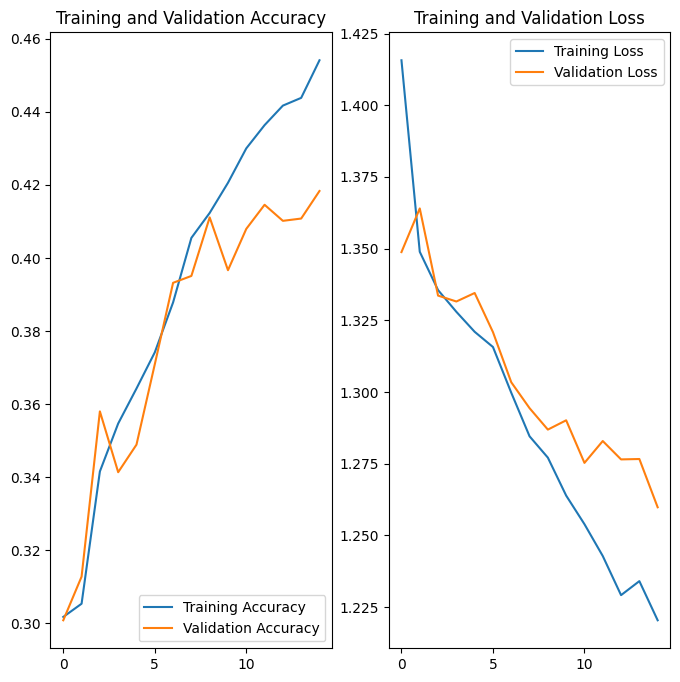

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
img = tf.keras.utils.load_img(
    './dogs/relaxed/13979947_7bd687d603_b.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to relaxed with a 38.46 percent confidence.
